In [1]:
import urllib  # Импортировали библиотеку для работы с адресами и запросами Internet.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve, make_scorer, precision_recall_curve, auc, average_precision_score

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import space_eval

import lightgbm as lgb
import xgboost as xgb

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
pd.options.display.max_columns = None

### Параметры

In [3]:
tax = 0.000097

In [4]:
#метрика для несбалансированных класов
def pr_auc_score(y_true, y_score):
    #Generates the Area Under the Curve for precision and recall.
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    return 'pr_auc', auc(recall, precision, reorder=True)

def pr_auc_score_xgb(preds, train_data):
    #Generates the Area Under the Curve for precision and recall.
    labels = train_data.get_label()
    y_true = np.ravel(labels)
    y_score = np.ravel(preds)
    return 'pr_auc', average_precision_score(y_true, y_score)

def pr_auc_score_lgb(preds, train_data):
    #Generates the Area Under the Curve for precision and recall.
    labels = train_data.get_label()
    y_true = np.ravel(labels)
    y_score = np.ravel(preds)
    return 'pr_auc', average_precision_score(y_true, y_score), True

# функция для балансировки классов
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label==1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

## Обработка данных 

In [43]:
data = pd.read_csv('EURUSD.csv', header=None)
data.columns=['date', 'time', 'open', 'max', 'min', 'close', 'vol']

# вычисляем данные 
data['mean_o'] = (data['open'] + data['close'])/2
data['mean_m'] = (data['max'] + data['min'])/2

data['delta_oc'] = (data['open']  - data['close'])
data['delta_mm'] = (data['max']   - data['min'])
data['delta_mo'] = (data['max']   - data['open'])
data['delta_cm'] = (data['close'] - data['min'])

data['delta0_oc'] = (data['open']  - data['close'])/data['mean_m']
data['delta0_mm'] = (data['max']   - data['min']  )/data['mean_m']
data['delta0_mo'] = (data['max']   - data['open'])/data['mean_m']
data['delta0_cm'] = (data['close'] - data['min'] )/data['mean_m']

In [44]:
# вычисляем разницу
data['diff'] = data['open'].diff(1)
data['diff_'] = data['open'].diff(5)
data['diff_'] = data['diff_'].shift(-5)


data['diff1'] =  data['diff'].shift(-1)
data['diff2'] =  data['diff'].shift(-2)
data['diff3'] =  data['diff'].shift(-3)
data['diff4'] =  data['diff'].shift(-4)
data['diff5'] =  data['diff'].shift(-5)

# конструируем индекс 
data['datetime'] = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(data['datetime'])
data.index = data['datetime']
data.drop(['date', 'time', 'datetime'], axis=1, inplace=True)
#data.dropna(inplace=True)

data.dropna(inplace=True)
data.tail(7)

,open,max,min,close,vol,mean_o,mean_m,delta_oc,delta_mm,delta_mo,delta_cm,delta0_oc,delta0_mm,delta0_mo,delta0_cm,diff,diff_,diff1,diff2,diff3,diff4,diff5
datetime,,,,,,,,,,,,,,,,,,,,,,
2017-11-10 21:46:00,1.1663,1.1664,1.1663,1.1663,7,1.16630,1.16635,0.0000,0.0001,0.0001,0.0000,0.000000,0.000086,0.000086,0.000000,0.0000,0.0003,0.0001,-0.0001,0.0002,0.0002,-0.0001
2017-11-10 21:47:00,1.1664,1.1664,1.1663,1.1664,3,1.16640,1.16635,0.0000,0.0001,0.0000,0.0001,0.000000,0.000086,0.000000,0.000086,0.0001,0.0002,-0.0001,0.0002,0.0002,-0.0001,0.0000
2017-11-10 21:48:00,1.1663,1.1664,1.1663,1.1664,4,1.16635,1.16635,-0.0001,0.0001,0.0001,0.0001,-0.000086,0.000086,0.000086,0.000086,-0.0001,0.0002,0.0002,0.0002,-0.0001,0.0000,-0.0001
2017-11-10 21:49:00,1.1665,1.1668,1.1665,1.1668,10,1.16665,1.16665,-0.0003,0.0003,0.0003,0.0003,-0.000257,0.000257,0.000257,0.000257,0.0002,-0.0001,0.0002,-0.0001,0.0000,-0.0001,-0.0001
2017-11-10 21:50:00,1.1667,1.1667,1.1664,1.1665,11,1.16660,1.16655,0.0002,0.0003,0.0000,0.0001,0.000171,0.000257,0.000000,0.000086,0.0002,-0.0003,-0.0001,0.0000,-0.0001,-0.0001,0.0000
2017-11-10 21:51:00,1.1666,1.1666,1.1665,1.1665,6,1.16655,1.16655,0.0001,0.0001,0.0000,0.0000,0.000086,0.000086,0.000000,0.000000,-0.0001,-0.0002,0.0000,-0.0001,-0.0001,0.0000,0.0000
2017-11-10 21:52:00,1.1666,1.1666,1.1666,1.1666,1,1.16660,1.16660,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,-0.0002,-0.0001,-0.0001,0.0000,0.0000,0.0000


In [45]:
data['delta5'] = data['diff_']/data['close']
data['delta5'] = data['delta5'].apply(lambda x: (np.abs(x)))

data['grow'] = data.apply(lambda x: 1 if (x['diff1']>=0 and x['diff2']>=0 and x['diff3']>=0 and 
                                          x['diff4']>=0 and x['diff5']>=0 and x['delta5']>(tax*2)) else 0, axis=1)
data['fall'] = data.apply(lambda x: 1 if (x['diff1']<=0 and x['diff2']<=0 and x['diff3']<=0 and 
                                          x['diff4']<=0 and x['diff5']<=0 and x['delta5']>(tax*2)) else 0, axis=1)

In [46]:
data.drop(['diff', 'diff_', 'diff1', 'diff2', 'diff3', 'diff4', 'diff5', 'delta5'], axis=1, inplace=True)
data.head(10)

,open,max,min,close,vol,mean_o,mean_m,delta_oc,delta_mm,delta_mo,delta_cm,delta0_oc,delta0_mm,delta0_mo,delta0_cm,grow,fall
datetime,,,,,,,,,,,,,,,,,
2017-08-02 13:35:00,1.1827,1.1827,1.1825,1.1826,20,1.18265,1.18260,0.0001,0.0002,0.0000,0.0001,0.000085,0.000169,0.000000,0.000085,0,0
2017-08-02 13:36:00,1.1825,1.1827,1.1824,1.1827,21,1.18260,1.18255,-0.0002,0.0003,0.0002,0.0003,-0.000169,0.000254,0.000169,0.000254,0,0
2017-08-02 13:37:00,1.1826,1.1828,1.1826,1.1828,13,1.18270,1.18270,-0.0002,0.0002,0.0002,0.0002,-0.000169,0.000169,0.000169,0.000169,0,0
2017-08-02 13:38:00,1.1827,1.1829,1.1827,1.1827,15,1.18270,1.18280,0.0000,0.0002,0.0002,0.0000,0.000000,0.000169,0.000169,0.000000,0,0
2017-08-02 13:39:00,1.1828,1.1828,1.1827,1.1827,6,1.18275,1.18275,0.0001,0.0001,0.0000,0.0000,0.000085,0.000085,0.000000,0.000000,0,0
2017-08-02 13:40:00,1.1828,1.1828,1.1827,1.1828,3,1.18280,1.18275,0.0000,0.0001,0.0000,0.0001,0.000000,0.000085,0.000000,0.000085,0,0
2017-08-02 13:41:00,1.1827,1.1831,1.1827,1.1831,11,1.18290,1.18290,-0.0004,0.0004,0.0004,0.0004,-0.000338,0.000338,0.000338,0.000338,0,0
2017-08-02 13:42:00,1.1832,1.1832,1.1831,1.1832,9,1.18320,1.18315,0.0000,0.0001,0.0000,0.0001,0.000000,0.000085,0.000000,0.000085,0,0
2017-08-02 13:43:00,1.1831,1.1832,1.1831,1.1831,9,1.18310,1.18315,0.0000,0.0001,0.0001,0.0000,0.000000,0.000085,0.000085,0.000000,0,0


In [47]:
print(data.shape)
print(data[data.grow == 1].shape)
print(data[data.fall == 1].shape)

(88329, 17)
(4103, 17)
(4162, 17)


```python
(88330, 17)
(9517, 17)
(9697, 17)```

In [49]:
data.to_excel('data_1m.xlsx')

In [50]:
data.to_pickle('data1m.pkl')

In [51]:
url = 'http://export.finam.ru/EURUSD_180101_180301.csv?market=5&em=83&code=EURUSD&apply=0&df=1&mf=0&yf=2018&from=01.01.2018&dt=1&mt=2&yt=2018&to=01.03.2018&p=2&f=EURUSD_180101_180301&e=.csv&cn=EURUSD&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=5&at=1&fsp=1'
data_f = pd.read_csv(url, delimiter=';')
#f = urllib.request.urlopen(url)   # Открыли соединение.
#data1 = f.read()   # Прочитали данные.
#f.close()          # Закрыли соединение.

In [52]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64101 entries, 0 to 64100
Data columns (total 7 columns):
<DATE>     64101 non-null int64
<TIME>     64101 non-null int64
<OPEN>     64101 non-null float64
<HIGH>     64101 non-null float64
<LOW>      64101 non-null float64
<CLOSE>    64101 non-null float64
<VOL>      64101 non-null int64
dtypes: float64(4), int64(3)
memory usage: 3.4 MB


In [55]:
data_f.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,20180101,10100,1.19966,1.19966,1.19966,1.19966,1
1,20180101,90200,1.20020,1.20020,1.20020,1.20020,1
2,20180101,90300,1.20020,1.20020,1.20020,1.20020,1
3,20180101,90400,1.20020,1.20020,1.20020,1.20020,1
4,20180101,90500,1.20020,1.20020,1.20020,1.20020,1


## Построение модели grow - классификация

In [27]:
#data=pd.read_pickle('data1m.pkl')

In [56]:
boost_round = 1500
nfolds = 5
test_size = 0.2
rand_state = 43
best_params =   {'application': 'binary'}

In [57]:
col2est1 = ['grow']
col2est2 = ['fall']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(col2est1 + col2est2, axis=1), data[col2est1 + col2est2], 
                                                    test_size=test_size, random_state=rand_state)

In [59]:
ld_train = lgb.Dataset(X_train, np.ravel(y_train.drop(col2est2, axis=1)))
ld_test = lgb.Dataset(X_test)

In [60]:
np.random.seed(rand_state)
res = lgb.cv(best_params, ld_train, num_boost_round=boost_round, nfold=nfolds, feval=pr_auc_score_lgb, early_stopping_rounds=20, 
             show_stdv=True, callbacks=[lgb.print_evaluation(period=1, show_stdv=True)])
print (res.get("pr_auc-mean")[-1])
best_num_boost_round = len(res[list(res)[0]])
print(best_num_boost_round)

[1]	cv_agg's binary_logloss: 0.614524 + 4.10848e-05	cv_agg's pr_auc: 0.080087 + 0.00372273
[2]	cv_agg's binary_logloss: 0.550229 + 6.66255e-05	cv_agg's pr_auc: 0.0803826 + 0.00287965
[3]	cv_agg's binary_logloss: 0.496863 + 0.000108268	cv_agg's pr_auc: 0.0803017 + 0.00333937
[4]	cv_agg's binary_logloss: 0.452083 + 0.00012946	cv_agg's pr_auc: 0.0803769 + 0.00330996
[5]	cv_agg's binary_logloss: 0.414147 + 0.000148779	cv_agg's pr_auc: 0.080595 + 0.00318781
[6]	cv_agg's binary_logloss: 0.38182 + 0.000180724	cv_agg's pr_auc: 0.0807297 + 0.0032978
[7]	cv_agg's binary_logloss: 0.354121 + 0.000201014	cv_agg's pr_auc: 0.080627 + 0.00351051
[8]	cv_agg's binary_logloss: 0.330278 + 0.000223755	cv_agg's pr_auc: 0.0807175 + 0.00378963
[9]	cv_agg's binary_logloss: 0.309691 + 0.000250833	cv_agg's pr_auc: 0.0812082 + 0.00396266
[10]	cv_agg's binary_logloss: 0.29189 + 0.000275815	cv_agg's pr_auc: 0.0811416 + 0.00411222
[11]	cv_agg's binary_logloss: 0.276468 + 0.000286843	cv_agg's pr_auc: 0.0813036 + 0.00

In [61]:
clf = lgb.train(best_params, ld_train, num_boost_round=best_num_boost_round, feval=pr_auc_score_lgb)
y_score = clf.predict(X_test)

In [62]:
y_test1 = y_test.drop(col2est2, axis=1)
pr_auc_score(y_test1, y_score)

('pr_auc', 0.095632777815455983)

Text(0.5,1,'2-class Precision-Recall curve: \naverage precision score=0.0957608429504\nAUC-PRC = 0.0956327778155')

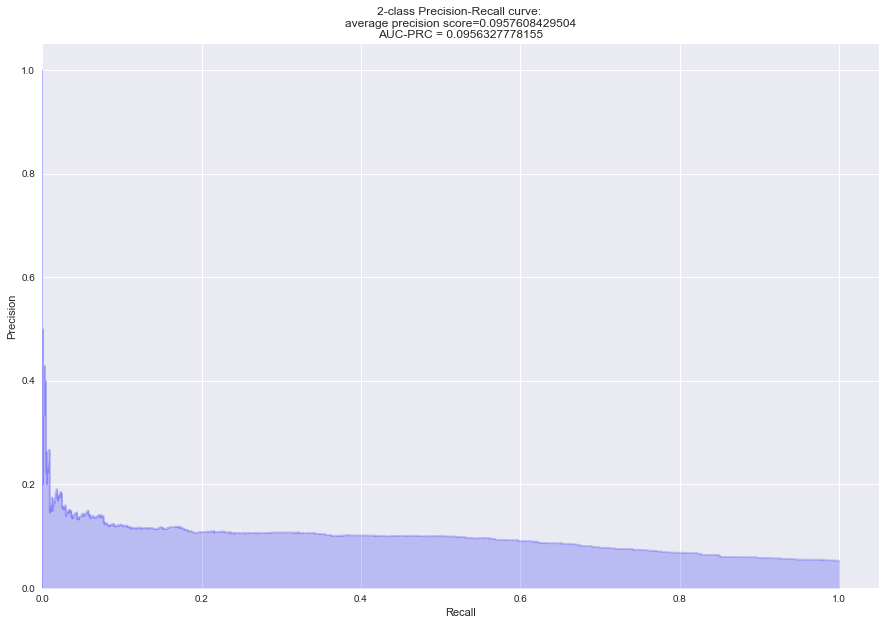

In [63]:
average_precision = average_precision_score(y_test1, y_score)

precisions, recalls, thresholds = precision_recall_curve(y_test1, y_score)
fig = plt.figure( figsize=(15, 10))
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: \naverage precision score='+ str(average_precision) + 
          '\nAUC-PRC = ' + str(auc(recalls, precisions, reorder=True)))

In [64]:
results = y_test.copy()
results['Score'] = y_score
res = list()
for i in np.arange(0, len(thresholds)):
    res.append(abs((1 - precisions[i]) - (1 - recalls[i])))

In [65]:
threshold = thresholds[np.argmin(res)]
precision = precisions[np.argmin(res)]
recall = recalls[np.argmin(res)]
print('threshold ', threshold, '\nprecision ', precision, '\nrecall ', recall)

threshold  0.105141910917 
precision  0.115201900238 
recall  0.115201900238


In [66]:
results['grow_b'] = results['Score'].apply(lambda x: 1 if x >= threshold  else 0)
print('FP: ', results[(results.grow_b==0) & (results.grow==1)].shape[0])
print('TP: ',results[(results.grow_b==1) & (results.grow==1)].shape[0])
print('FN: ', results[(results.grow_b==1) & (results.grow==0)].shape[0])
print('TN: ',results[(results.grow_b==0) & (results.grow==0)].shape[0])
results[results.grow_b==1].sort_values('Score', ascending=False).tail(50)

FP:  745
TP:  97
FN:  745
TN:  16079


,grow,fall,Score,grow_b
datetime,,,,
2017-08-30 09:23:00,0,0,0.106681,1
2017-09-06 01:54:00,0,0,0.106681,1
2017-09-05 01:40:00,1,0,0.106681,1
2017-08-10 07:16:00,0,0,0.106635,1
2017-10-24 12:23:00,0,0,0.106607,1
2017-08-20 21:05:00,0,0,0.106607,1
2017-09-21 07:36:00,0,0,0.106535,1
2017-09-20 20:46:00,0,0,0.106535,1
2017-08-17 17:26:00,1,0,0.106503,1


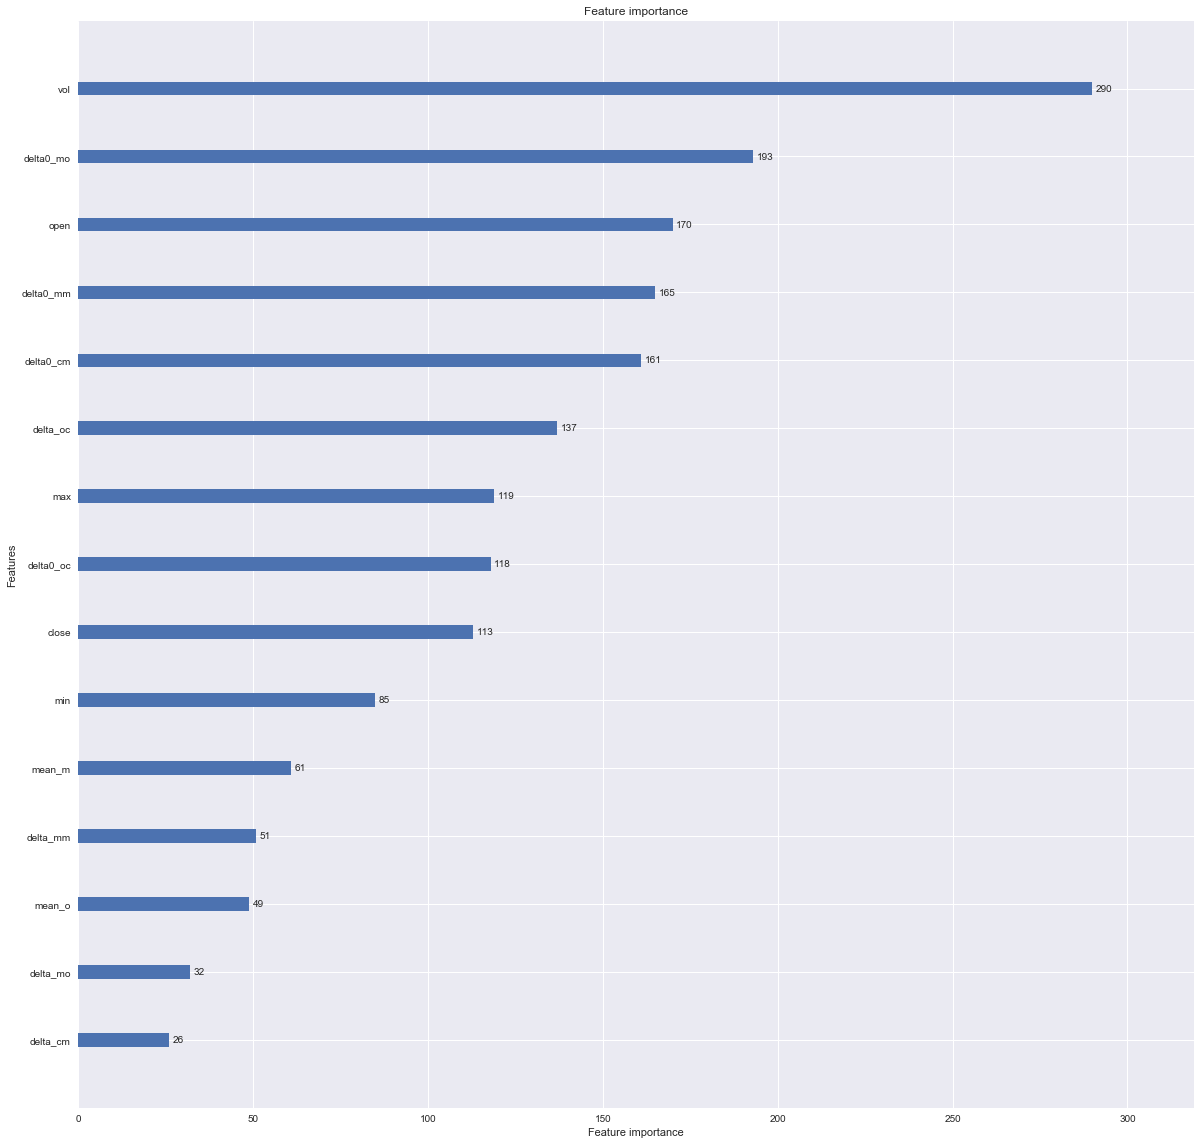

In [67]:
fig = plt.figure( figsize=(20, 20))
ax = fig.add_subplot(111)
lgb.plot_importance(clf, ax)

## CNN

In [44]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Conv1D, MaxPooling1D

In [29]:
data=pd.read_pickle('data1m.pkl')

In [51]:
def split_into_chunks(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                if scale: x_i = preprocessing.scale(x_i)
            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]
        except:
            break

        X.append(x_i)
        Y.append(y_i)
    return X, Y

def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


def create_Xt_Yt(X, y, percentage=0.8):
    split_index = int(len(X) * percentage)
    X_train = X[0:split_index]
    Y_train = y[0:split_index]
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)
    X_test = X[split_index:]
    Y_test = y[split_index:]
    return X_train, X_test, Y_train, Y_test

In [72]:
TRAIN_SIZE = 4#20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

In [35]:
data.head()

,open,max,min,close,vol,mean_o,mean_m,delta_oc,delta_mm,delta_mo,delta_cm,delta0_oc,delta0_mm,delta0_mo,delta0_cm,grow,fall
datetime,,,,,,,,,,,,,,,,,
2017-08-02 13:34:00,1.1823,1.1826,1.1822,1.1826,14,1.18245,1.18240,-0.0003,0.0004,0.0003,0.0004,-0.000254,0.000338,0.000254,0.000338,0,0
2017-08-02 13:35:00,1.1827,1.1827,1.1825,1.1826,20,1.18265,1.18260,0.0001,0.0002,0.0000,0.0001,0.000085,0.000169,0.000000,0.000085,0,0
2017-08-02 13:36:00,1.1825,1.1827,1.1824,1.1827,21,1.18260,1.18255,-0.0002,0.0003,0.0002,0.0003,-0.000169,0.000254,0.000169,0.000254,1,0
2017-08-02 13:37:00,1.1826,1.1828,1.1826,1.1828,13,1.18270,1.18270,-0.0002,0.0002,0.0002,0.0002,-0.000169,0.000169,0.000169,0.000169,1,0
2017-08-02 13:38:00,1.1827,1.1829,1.1827,1.1827,15,1.18270,1.18280,0.0000,0.0002,0.0002,0.0000,0.000000,0.000169,0.000169,0.000000,0,0


In [73]:
X = data[['open', 'max', 'min', 'close']].as_matrix()
X = np.expand_dims(X, axis=2)
Y = data.grow.as_matrix()

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

In [74]:
X_train.shape

(79497, 4, 1)

In [75]:
model = Sequential()
model.add(Conv1D(input_shape=(TRAIN_SIZE, EMB_SIZE), nb_filter=64, filter_length=2, border_mode='valid',
                        activation='relu',subsample_length=1))
model.add(MaxPooling1D(pool_length=2))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(250))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(4, 1), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


In [76]:
model.fit(X_train, 
          Y_train, 
          nb_epoch=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)
print( score)

C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


ValueError: Error when checking target: expected activation_14 to have shape (None, 2) but got array with shape (79497, 1)

In [87]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

# Generate dummy data
x_train = np.random.random((100, 100, 3))
y_train = keras.utils.to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)
x_test = np.random.random((20, 100, 3))
y_test = keras.utils.to_categorical(np.random.randint(10, size=(20, 1)), num_classes=10)

seq_length = 100

In [90]:
y_train.shape

(100, 10)

In [88]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(seq_length, 100)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=16, epochs=10)
score = model.evaluate(x_test, y_test, batch_size=16)

ValueError: Error when checking input: expected conv1d_23_input to have shape (None, 100, 100) but got array with shape (100, 100, 3)

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

Using TensorFlow backend.


In [2]:
data_dim = 16
timesteps = 8
num_classes = 10

In [3]:
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(32, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [4]:
# Generate dummy training data
x_train = np.random.random((1000, timesteps, data_dim))
y_train = np.random.random((1000, num_classes))

# Generate dummy validation data
x_val = np.random.random((100, timesteps, data_dim))
y_val = np.random.random((100, num_classes))

In [5]:
print(x_train.shape, y_train.shape)
x_train[0,:,:]

(1000, 8, 16) (1000, 10)


array([[ 0.8955732 ,  0.15116513,  0.39923663,  0.54574791,  0.7610251 ,
         0.59191697,  0.62773906,  0.90783009,  0.34252092,  0.05784188,
         0.96964029,  0.40919844,  0.67944527,  0.95823544,  0.08185391,
         0.8162642 ],
       [ 0.95455267,  0.17185269,  0.12955127,  0.0822974 ,  0.45698906,
         0.39678114,  0.59042673,  0.01320739,  0.38751251,  0.00240044,
         0.50083099,  0.27969719,  0.78897392,  0.10487728,  0.6845773 ,
         0.91358408],
       [ 0.45441387,  0.15856469,  0.0821934 ,  0.86016905,  0.82666084,
         0.56482508,  0.59811384,  0.36376587,  0.72617197,  0.26919558,
         0.69170716,  0.58170036,  0.73216571,  0.05045993,  0.44393321,
         0.32478503],
       [ 0.03077749,  0.80325066,  0.36026975,  0.95123072,  0.42730472,
         0.74857368,  0.38475319,  0.71882649,  0.04665034,  0.20541235,
         0.54695494,  0.01013165,  0.19208701,  0.83537294,  0.22857424,
         0.51523119],
       [ 0.47576071,  0.67747395,  0

In [6]:
x_train[1,:,:]

array([[ 0.59252216,  0.07560714,  0.40241424,  0.78653956,  0.27248371,
         0.2757032 ,  0.01173844,  0.27957977,  0.87201256,  0.20298428,
         0.13443455,  0.58802985,  0.25167545,  0.93319295,  0.865794  ,
         0.09402852],
       [ 0.47102034,  0.73059835,  0.01090737,  0.17850708,  0.26455481,
         0.51765704,  0.5288657 ,  0.6120069 ,  0.43284265,  0.99391428,
         0.72285324,  0.28137316,  0.39131563,  0.98672924,  0.40094932,
         0.61283804],
       [ 0.42255133,  0.4394317 ,  0.5984509 ,  0.05295668,  0.738166  ,
         0.57729382,  0.0535484 ,  0.05348611,  0.97536326,  0.59430258,
         0.4872949 ,  0.05306493,  0.48556472,  0.10778279,  0.39055361,
         0.08915171],
       [ 0.97037575,  0.28396921,  0.34996239,  0.78962538,  0.48272778,
         0.58470969,  0.11179455,  0.31540549,  0.76134655,  0.72757067,
         0.93504611,  0.25958214,  0.18496891,  0.83190446,  0.36441549,
         0.02450206],
       [ 0.79808804,  0.93485645,  0

In [7]:
model.fit(x_train, y_train,
          batch_size=64, epochs=5,
          validation_data=(x_val, y_val))

Train on 1000 samples, validate on 100 samples
Epoch 1/5
1000/1000 [==============================] - 13s 13ms/step - loss: 11.5626 - acc: 0.1030 - val_loss: 11.6152 - val_acc: 0.1300